# Model Performance Comparison

This notebook provides visualization and analysis of model performance across different puzzle sizes. It reads data from a CSV file containing performance metrics and generates:

1. A visual comparison plot with different colors for each puzzle size
2. Statistical summary of performance metrics
3. Option to save the plot as an image file

The input CSV file should have the following columns:
- Model: The name/type of the model
- Size: The puzzle size
- PuzzleFile: The name of the puzzle file used
- Metric1: Primary performance metric (e.g., accuracy)
- Metric2: Secondary performance metric

Plot saved to model_comparison.png


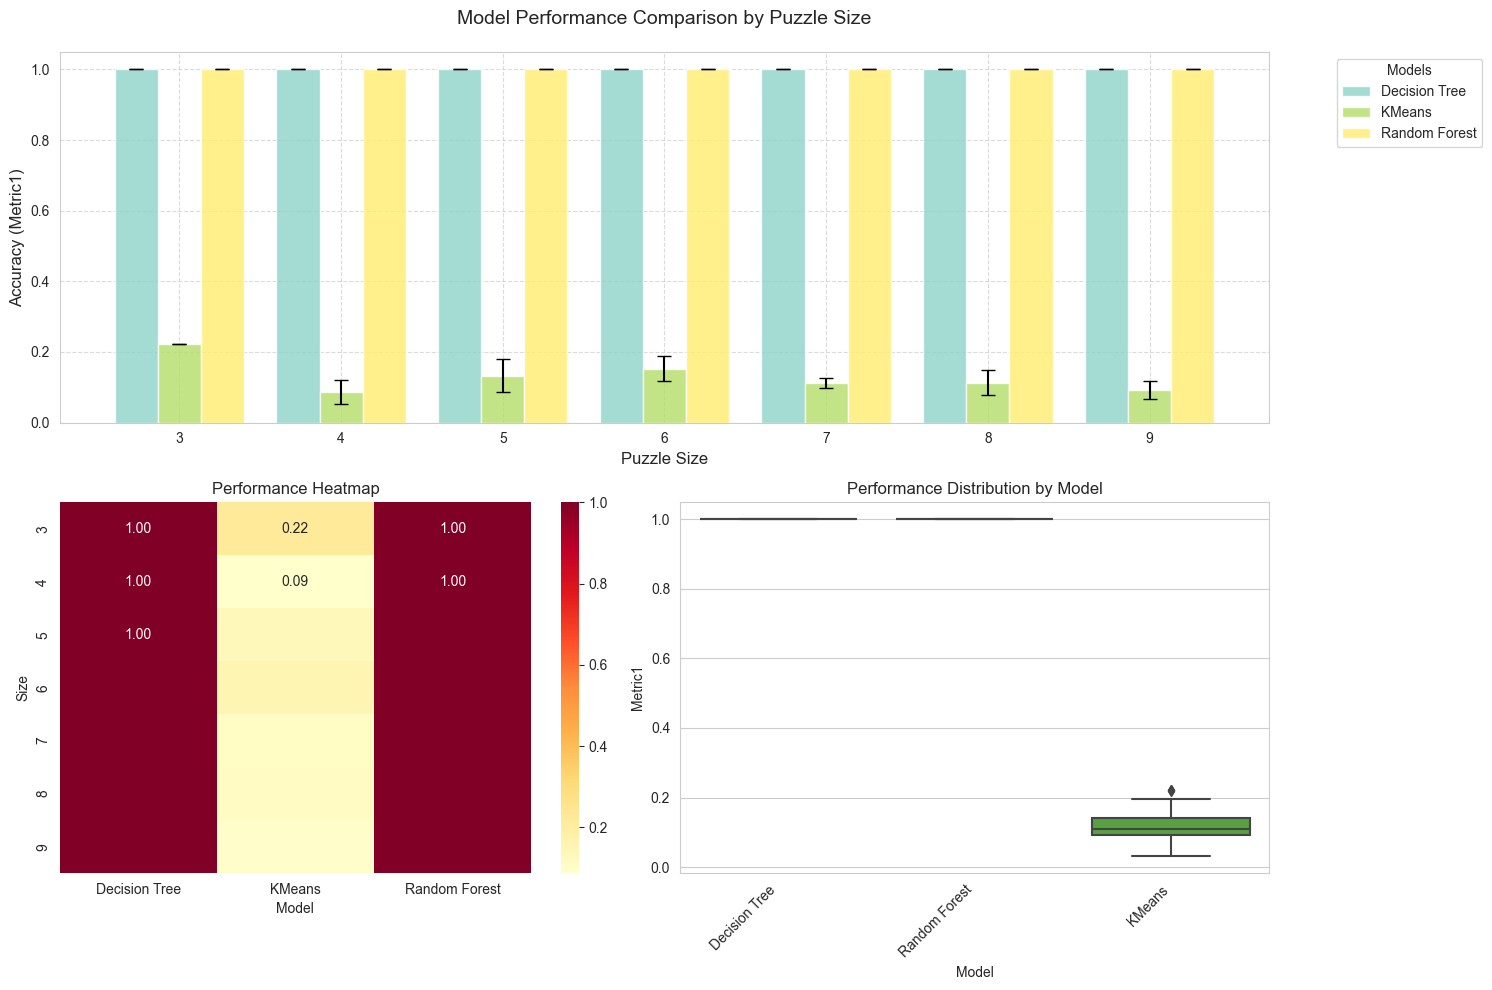


Detailed Statistical Summary:

Overall Best Performance:
Model: Decision Tree
Size: 8
Accuracy: 1.00

Performance by Puzzle Size:

Size 3:
Best Model: Decision Tree
Mean Accuracy: 0.88 ± 0.29
Model Ranking:
1. Decision Tree: 1.00
2. Random Forest: 1.00
3. KMeans: 0.22

Size 4:
Best Model: Random Forest
Mean Accuracy: 0.54 ± 0.48
Model Ranking:
1. Decision Tree: 1.00
2. Random Forest: 1.00
3. KMeans: 0.09

Size 5:
Best Model: Decision Tree
Mean Accuracy: 0.71 ± 0.43
Model Ranking:
1. Decision Tree: 1.00
2. Random Forest: 1.00
3. KMeans: 0.13

Size 6:
Best Model: Random Forest
Mean Accuracy: 0.69 ± 0.43
Model Ranking:
1. Decision Tree: 1.00
2. Random Forest: 1.00
3. KMeans: 0.15

Size 7:
Best Model: Random Forest
Mean Accuracy: 0.78 ± 0.41
Model Ranking:
1. Decision Tree: 1.00
2. Random Forest: 1.00
3. KMeans: 0.11

Size 8:
Best Model: Decision Tree
Mean Accuracy: 0.15 ± 0.18
Model Ranking:
1. Decision Tree: 1.00
2. Random Forest: 1.00
3. KMeans: 0.11

Size 9:
Best Model: Decision Tree


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
from matplotlib.gridspec import GridSpec

# Try to import seaborn for better styling, fallback to built-in style
try:
    import seaborn as sns
    sns.set_style('whitegrid')
    sns.set_palette('husl')
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    plt.style.use('classic')

def plot_accuracy_comparison(csv_path: str, figsize: tuple = (15, 10), save_plot: bool = False, output_path: Optional[str] = None) -> None:
    """
    Visualizes model performance comparison from CSV data with enhanced visualization.
    Handles missing data points gracefully.
    
    Args:
        csv_path: Path to the CSV file containing performance data
        figsize: Tuple specifying figure dimensions (width, height)
        save_plot: Whether to save the plot to file
        output_path: Path where to save the plot if save_plot is True
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path, header=None, names=['Model', 'Size', 'PuzzleFile', 'Metric1', 'Metric2', 'Extra'])
        
        # Validate required columns
        required_cols = ['Model', 'Size', 'Metric1']
        if not all(col in df.columns for col in required_cols):
            raise ValueError("Missing required columns in CSV file")

        # Drop any empty columns if present
        df = df.drop(columns=['Extra'], errors='ignore')

        # Convert Size to int and metrics to float
        df['Size'] = df['Size'].astype(int)
        df['Metric1'] = pd.to_numeric(df['Metric1'], errors='coerce')
        df['Metric2'] = pd.to_numeric(df['Metric2'], errors='coerce')

        # Create figure with GridSpec for better layout
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(2, 2, figure=fig)
        
        # Main performance plot (larger)
        ax1 = fig.add_subplot(gs[0, :])
        
        # Get unique models and sizes
        unique_models = sorted(df['Model'].unique())
        unique_sizes = sorted(df['Size'].unique())
        
        # Create color map for different models
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_models)))
        
        # Calculate bar positions
        x = np.arange(len(unique_sizes))
        width = 0.8 / len(unique_models)
        
        # Plot data with error bars grouped by model
        for idx, (model, color) in enumerate(zip(unique_models, colors)):
            model_data = df[df['Model'] == model]
            means = []
            stds = []
            positions = []
            
            for size in unique_sizes:
                size_data = model_data[model_data['Size'] == size]
                if not size_data.empty and not size_data['Metric1'].isna().all():
                    means.append(size_data['Metric1'].mean())
                    stds.append(size_data['Metric1'].std())
                    positions.append(x[unique_sizes.index(size)])
            
            if means:  # Only plot if we have data for this model
                ax1.bar([pos + idx * width for pos in positions], 
                        means,
                        width, 
                        label=model,
                        color=color,
                        alpha=0.8)
                ax1.errorbar([pos + idx * width for pos in positions], 
                            means, 
                            yerr=stds,
                            fmt='none', 
                            color='black', 
                            capsize=5)

        ax1.set_title('Model Performance Comparison by Puzzle Size', fontsize=14, pad=20)
        ax1.set_xlabel('Puzzle Size', fontsize=12)
        ax1.set_ylabel('Accuracy (Metric1)', fontsize=12)
        ax1.set_xticks(x + width * (len(unique_models) - 1) / 2)
        ax1.set_xticklabels(unique_sizes)
        ax1.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Performance heatmap
        ax2 = fig.add_subplot(gs[1, 0])
        pivot_data = df.pivot_table(values='Metric1', 
                                   index='Size', 
                                   columns='Model', 
                                   aggfunc='mean')
        if HAS_SEABORN:
            sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax2)
        else:
            im = ax2.imshow(pivot_data, cmap='YlOrRd', aspect='auto')
            plt.colorbar(im, ax=ax2)
            # Add annotations
            for i in range(len(pivot_data.index)):
                for j in range(len(pivot_data.columns)):
                    if not np.isnan(pivot_data.iloc[i, j]):
                        ax2.text(j, i, f'{pivot_data.iloc[i, j]:.2f}',
                                ha='center', va='center')
        ax2.set_title('Performance Heatmap')
        if not HAS_SEABORN:
            ax2.set_xticks(np.arange(len(pivot_data.columns)))
            ax2.set_yticks(np.arange(len(pivot_data.index)))
            ax2.set_xticklabels(pivot_data.columns)
            ax2.set_yticklabels(pivot_data.index)
        
        # Box plot
        ax3 = fig.add_subplot(gs[1, 1])
        if HAS_SEABORN:
            sns.boxplot(data=df, x='Model', y='Metric1', ax=ax3)
        else:
            df.boxplot(column='Metric1', by='Model', ax=ax3)
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
        ax3.set_title('Performance Distribution by Model')
        
        plt.tight_layout()

        # Save plot if requested
        if save_plot:
            if output_path is None:
                output_path = 'model_comparison.png'
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {output_path}")

        plt.show()

        # Print detailed statistical summary
        print("\nDetailed Statistical Summary:")
        
        # Overall best model (excluding NaN values)
        valid_data = df[df['Metric1'].notna()]
        if not valid_data.empty:
            best_model = valid_data.loc[valid_data['Metric1'].idxmax()]
            print(f"\nOverall Best Performance:")
            print(f"Model: {best_model['Model']}")
            print(f"Size: {best_model['Size']}")
            print(f"Accuracy: {best_model['Metric1']:.2f}")
        else:
            print("\nNo valid performance data found.")
        
        # Performance by size
        print("\nPerformance by Puzzle Size:")
        for size in sorted(df['Size'].unique()):
            subset = df[df['Size'] == size]
            valid_subset = subset[subset['Metric1'].notna()]
            
            print(f"\nSize {size}:")
            if not valid_subset.empty:
                best_idx = valid_subset['Metric1'].idxmax()
                print(f"Best Model: {valid_subset.loc[best_idx, 'Model']}")
                print(f"Mean Accuracy: {valid_subset['Metric1'].mean():.2f} ± {valid_subset['Metric1'].std():.2f}")
                
                # Model ranking for this size
                model_ranking = valid_subset.groupby('Model')['Metric1'].mean().sort_values(ascending=False)
                print("Model Ranking:")
                for rank, (model, score) in enumerate(model_ranking.items(), 1):
                    print(f"{rank}. {model}: {score:.2f}")
            else:
                print("No valid data available for this size")
            
    except FileNotFoundError:
        print(f"Error: File {csv_path} not found")
        return
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        import traceback
        traceback.print_exc()
        return

# Example usage with larger figure size and save enabled
plot_accuracy_comparison('../accuracy_results.csv', figsize=(15, 10), save_plot=True)




Plot saved to nodes_results_comparison.png


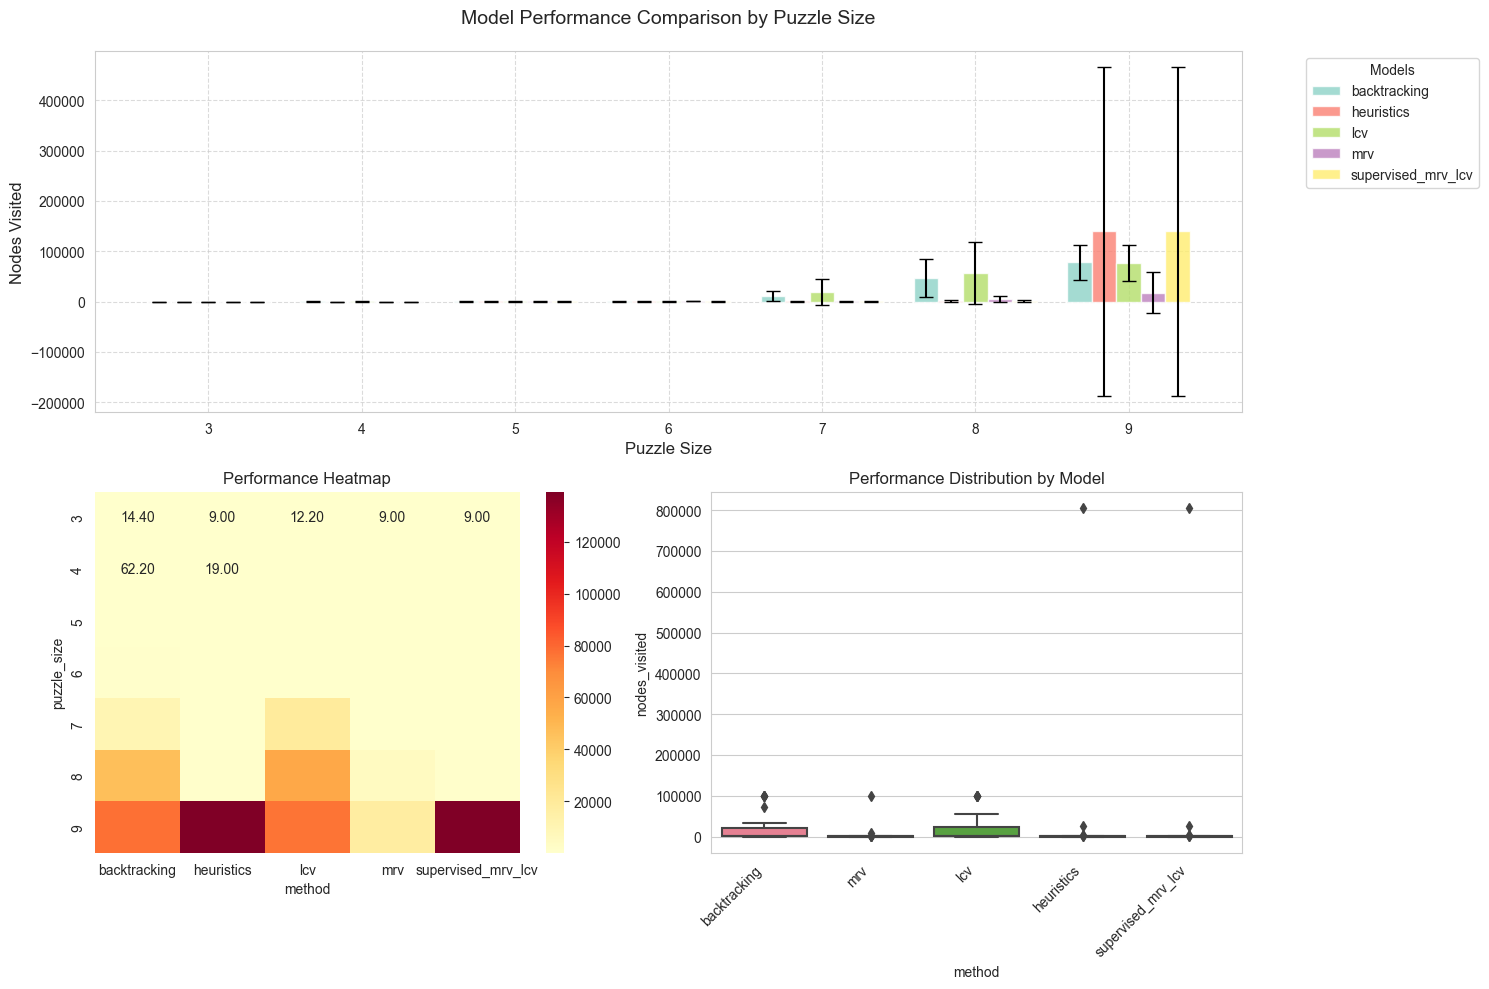


Detailed Statistical Summary:

Overall Best Performance:
Model: mrv
Size: 3
Nodes Visited: 9.00

Performance by Puzzle Size:

Size 3:
Best Model: mrv
Mean Nodes Visited: 10.72 ± 3.53
Model Ranking:
1. heuristics: 9.00
2. mrv: 9.00
3. supervised_mrv_lcv: 9.00
4. lcv: 12.20
5. backtracking: 14.40

Size 4:
Best Model: mrv
Mean Nodes Visited: 35.88 ± 37.36
Model Ranking:
1. mrv: 18.20
2. heuristics: 19.00
3. supervised_mrv_lcv: 19.00
4. lcv: 61.00
5. backtracking: 62.20

Size 5:
Best Model: mrv
Mean Nodes Visited: 99.00 ± 129.15
Model Ranking:
1. heuristics: 45.86
2. supervised_mrv_lcv: 45.86
3. mrv: 61.57
4. backtracking: 139.86
5. lcv: 201.86

Size 6:
Best Model: mrv
Mean Nodes Visited: 272.45 ± 547.63
Model Ranking:
1. mrv: 44.75
2. heuristics: 71.25
3. supervised_mrv_lcv: 71.25
4. lcv: 515.75
5. backtracking: 659.25

Size 7:
Best Model: mrv
Mean Nodes Visited: 6217.25 ± 13643.34
Model Ranking:
1. heuristics: 365.25
2. supervised_mrv_lcv: 365.25
3. mrv: 473.00
4. backtracking: 10297.25

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
from matplotlib.gridspec import GridSpec

# Try to import seaborn for better styling, fallback to built-in style
try:
    import seaborn as sns
    sns.set_style('whitegrid')
    sns.set_palette('husl')
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    plt.style.use('classic')

def plot_nodes_results(csv_path: str, figsize: tuple = (15, 10), save_plot: bool = False, output_path: Optional[str] = None) -> None:
    """
    Visualizes model performance comparison from nodes_results.csv data with enhanced visualization.
    Handles missing data points gracefully.
    
    Args:
        csv_path: Path to the CSV file containing performance data
        figsize: Tuple specifying figure dimensions (width, height)
        save_plot: Whether to save the plot to file
        output_path: Path where to save the plot if save_plot is True
    """
    try:
       # Define column names as the CSV doesn't have a header
        column_names = ['method', 'puzzle_size', 'json_filename', 'nodes_visited', 'time_taken']
        # Read the CSV file, specifying no header and providing column names
        df = pd.read_csv(csv_path, header=None, names=column_names)

        # Validate required columns
        required_cols = ['method', 'puzzle_size', 'nodes_visited']
        if not all(col in df.columns for col in required_cols):
            raise ValueError("Missing required columns in CSV file")

        # Convert puzzle_size to int and nodes_visited to float
        df['puzzle_size'] = pd.to_numeric(df['puzzle_size'], errors='coerce').astype('Int64')
        df['nodes_visited'] = pd.to_numeric(df['nodes_visited'], errors='coerce')

        # Create figure with GridSpec for better layout
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(2, 2, figure=fig)
        
        # Main performance plot (larger)
        ax1 = fig.add_subplot(gs[0, :])
        
        # Get unique models and sizes
        unique_models = sorted(df['method'].unique())
        unique_sizes = sorted(df['puzzle_size'].dropna().unique())
        
        # Create color map for different models
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_models)))
        
        # Calculate bar positions
        x = np.arange(len(unique_sizes))
        width = 0.8 / len(unique_models)
        
        # Plot data with error bars grouped by model
        for idx, (model, color) in enumerate(zip(unique_models, colors)):
            model_data = df[df['method'] == model]
            means = []
            stds = []
            positions = []
            
            for size in unique_sizes:
                size_data = model_data[model_data['puzzle_size'] == size]
                if not size_data.empty and not size_data['nodes_visited'].isna().all():
                    means.append(size_data['nodes_visited'].mean())
                    stds.append(size_data['nodes_visited'].std())
                    positions.append(x[unique_sizes.index(size)])
            
            if means:  # Only plot if we have data for this model
                ax1.bar([pos + idx * width for pos in positions], 
                        means,
                        width, 
                        label=model,
                        color=color,
                        alpha=0.8)
                ax1.errorbar([pos + idx * width for pos in positions], 
                            means, 
                            yerr=stds,
                            fmt='none', 
                            color='black', 
                            capsize=5)

        ax1.set_title('Model Performance Comparison by Puzzle Size', fontsize=14, pad=20)
        ax1.set_xlabel('Puzzle Size', fontsize=12)
        ax1.set_ylabel('Nodes Visited', fontsize=12)
        ax1.set_xticks(x + width * (len(unique_models) - 1) / 2)
        ax1.set_xticklabels(unique_sizes)
        ax1.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Performance heatmap
        ax2 = fig.add_subplot(gs[1, 0])
        pivot_data = df.pivot_table(values='nodes_visited', 
                                   index='puzzle_size', 
                                   columns='method', 
                                   aggfunc='mean')
        if HAS_SEABORN:
            sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax2)
        else:
            im = ax2.imshow(pivot_data, cmap='YlOrRd', aspect='auto')
            plt.colorbar(im, ax=ax2)
            # Add annotations
            for i in range(len(pivot_data.index)):
                for j in range(len(pivot_data.columns)):
                    if not np.isnan(pivot_data.iloc[i, j]):
                        ax2.text(j, i, f'{pivot_data.iloc[i, j]:.2f}',
                                ha='center', va='center')
        ax2.set_title('Performance Heatmap')
        if not HAS_SEABORN:
            ax2.set_xticks(np.arange(len(pivot_data.columns)))
            ax2.set_yticks(np.arange(len(pivot_data.index)))
            ax2.set_xticklabels(pivot_data.columns)
            ax2.set_yticklabels(pivot_data.index)
        
        # Box plot
        ax3 = fig.add_subplot(gs[1, 1])
        if HAS_SEABORN:
            sns.boxplot(data=df, x='method', y='nodes_visited', ax=ax3)
        else:
            df.boxplot(column='nodes_visited', by='method', ax=ax3)
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
        ax3.set_title('Performance Distribution by Model')
        
        plt.tight_layout()

        # Save plot if requested
        if save_plot:
            if output_path is None:
                output_path = 'nodes_results_comparison.png'
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {output_path}")

        plt.show()

        # Print detailed statistical summary
        print("\nDetailed Statistical Summary:")
        
        # Overall best model (excluding NaN values)
        valid_data = df[df['nodes_visited'].notna()]
        if not valid_data.empty:
            best_model = valid_data.loc[valid_data['nodes_visited'].idxmin()]  # Assuming lower nodes_visited is better
            print(f"\nOverall Best Performance:")
            print(f"Model: {best_model['method']}")
            print(f"Size: {best_model['puzzle_size']}")
            print(f"Nodes Visited: {best_model['nodes_visited']:.2f}")
        else:
            print("\nNo valid performance data found.")
        
        # Performance by size
        print("\nPerformance by Puzzle Size:")
        for size in sorted(df['puzzle_size'].dropna().unique()):
            subset = df[df['puzzle_size'] == size]
            valid_subset = subset[subset['nodes_visited'].notna()]
            
            print(f"\nSize {size}:")
            if not valid_subset.empty:
                best_idx = valid_subset['nodes_visited'].idxmin()  # Lower is better
                print(f"Best Model: {valid_subset.loc[best_idx, 'method']}")
                print(f"Mean Nodes Visited: {valid_subset['nodes_visited'].mean():.2f} ± {valid_subset['nodes_visited'].std():.2f}")
                
                # Model ranking for this size
                model_ranking = valid_subset.groupby('method')['nodes_visited'].mean().sort_values()
                print("Model Ranking:")
                for rank, (model, score) in enumerate(model_ranking.items(), 1):
                    print(f"{rank}. {model}: {score:.2f}")
            else:
                print("No valid data available for this size")
            
    except FileNotFoundError:
        print(f"Error: File {csv_path} not found")
        return
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        import traceback
        traceback.print_exc()
        return

# Example usage with larger figure size and save enabled
if __name__ == "__main__":
    plot_nodes_results('../nodes_results.csv', figsize=(15, 10), save_plot=True)
